# Model interpretation

In [21]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [9]:
MODELS = "../models/"
DATA = "../data/"


## Most predictive words of fake news.
We analyze the weights of the best __Logistic Regression__ to find which words are the most indicative of fake news and real news. According to the results obtained in the the `model_evaluation.ipynb` notebook, Logistic Regression with L2 penalty had slightly greater scores in all performance metrics so we use it for interpretation.

In [27]:
# Load the model
lr_l2 = joblib.load(MODELS + "lr_l2.pkl")

# Load the vectorizer object to map column indices back to their corresponding words
vectorizer = joblib.load(DATA + "vectorizer.pkl")

In [28]:
features = vectorizer.get_feature_names_out()
l2_weights = lr_l2.coef_[0]


In [29]:
# Sort the indexes of the weights by their corresponding weight value
idx_sorted = np.argsort(l2_weights)

# The largest weights will be at the end of the array
fake_news_idx = idx_sorted[-10:]
fake_news_words = [features[idx] for idx in fake_news_idx]
fake_news_weights = [l2_weights[idx] for idx in fake_news_idx]

# The smallest weights will be in the beggining of the array
real_news_idx = idx_sorted[:10]
real_news_words = [features[idx] for idx in real_news_idx]
real_news_weights = [l2_weights[idx] for idx in real_news_idx]

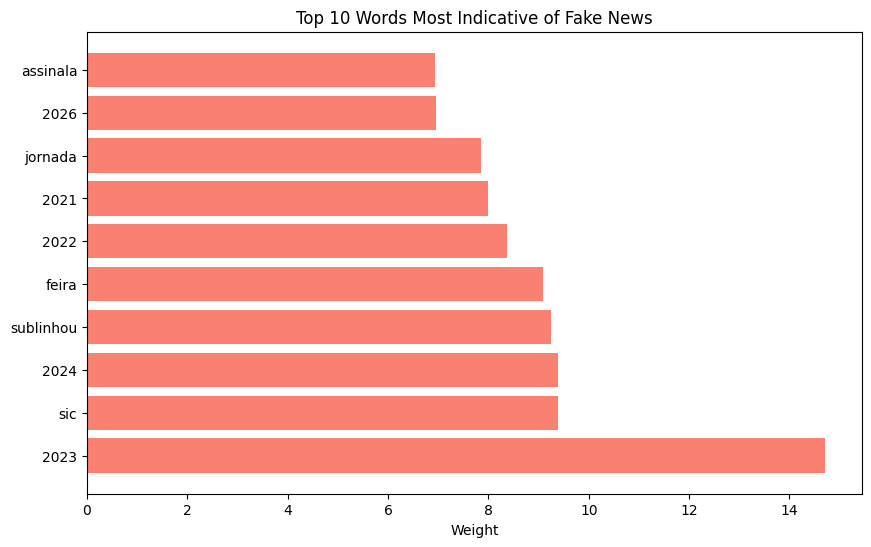

In [30]:
plt.figure(figsize=(10,6))
plt.barh(fake_news_words, fake_news_weights, color='salmon')
plt.xlabel('Weight')
plt.title('Top 10 Words Most Indicative of Fake News')
plt.gca().invert_yaxis() 
plt.show()

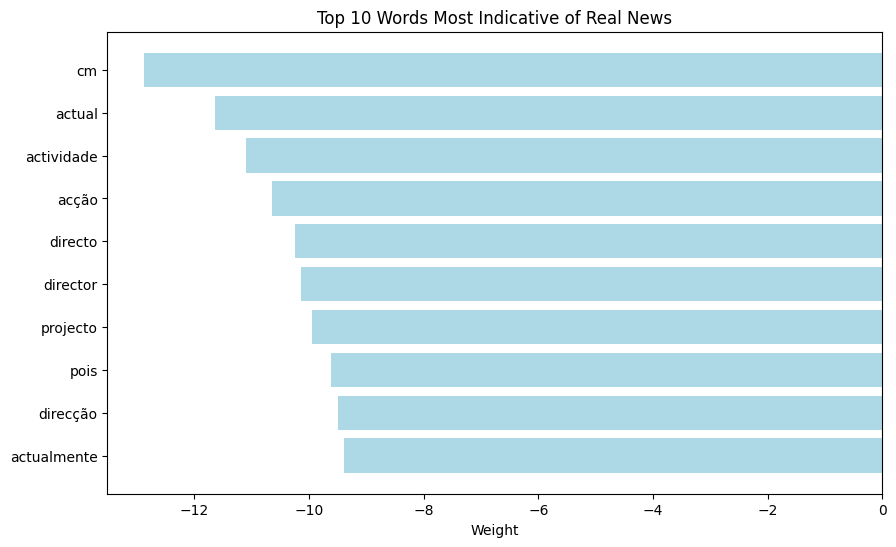

In [31]:
plt.figure(figsize=(10,6))
plt.barh(real_news_words, real_news_weights, color='lightblue')
plt.xlabel('Weight')
plt.title('Top 10 Words Most Indicative of Real News')
plt.gca().invert_yaxis() 
plt.show()

## Comparing number of non-zero weights in Logistic Regression with L1 and L2 penalty

In [26]:
# Load Logistic Regression with L1 penalty
lr_l1 = joblib.load(MODELS + "lr_l1.pkl")

In [33]:
threshold = 0.0001
l1_weights = lr_l1.coef_[0]

l1_non_zero_weights = len([w for w in l1_weights if abs(w) > threshold])
l2_non_zero_weights = len([w for w in l2_weights if abs(w) > threshold])

print("Number of non zero weights in Logistic Regression:")
print("\tL1 penalty: ", l1_non_zero_weights)
print("\tL2 penalty: ", l2_non_zero_weights)

Number of non zero weights in Logistic Regression:
	L1 penalty:  2019
	L2 penalty:  4999
